### Detecting Heart Abnormalities from Phonocardiograms with Parallel Recurrent and Convolutional Neural Networks

##### CNN with Spectrogram Features (Spatial) and BiLSTM with MFCC Features (Temporal)

##### Dataset from PhysioNet Computing in Cardiology 2016 Challenge

#### Test Helper Functions From Heart Module

In [2]:
from heart import *
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
from keras import Model
from keras.layers import Dense, Conv2D, LSTM, Bidirectional, MaxPooling2D, Flatten, Activation, Input, concatenate
import warnings
warnings.filterwarnings('ignore')

In [3]:
labels = get_labels('./data/classes/')
labels[0]

['abnormal', 'normal']

In [4]:
spec = wav2spec('data/sample_audio/a0001.wav')
mfcc = wav2mfcc('data/sample_audio/a0001.wav')

In [5]:
print(spec.shape)
print(mfcc.shape)

(129, 47)
(20, 47)


#### Save Dataset Features

In [ ]:
save_data_to_mfcc_tensor(path='./data/train_seg/', max_seconds=4, dest_dir_path='./data/numpy/train/mfcc/')
save_data_to_mfcc_tensor(path='./data/test_seg/', max_seconds=4, dest_dir_path='./data/numpy/test/mfcc/')

In [ ]:
save_data_to_spec_tensor(path='./data/train_seg/', max_seconds=4, dest_dir_path='./data/numpy/train/spec/')
save_data_to_spec_tensor(path='./data/test_seg/', max_seconds=4, dest_dir_path='./data/numpy/test/spec/')

#### Load Features

In [6]:
X_train_mfcc, y_train_mfcc = load_tensor_from_numpy(data_path='./data/classes/', numpy_path='./data/numpy/train/mfcc/')
X_test_mfcc, y_test_mfcc = load_tensor_from_numpy(data_path='./data/classes/', numpy_path='./data/numpy/test/mfcc/')
X_train_spec, y_train_spec = load_tensor_from_numpy(data_path='./data/classes/', numpy_path='./data/numpy/train/spec/')
X_test_spec, y_test_spec = load_tensor_from_numpy(data_path='./data/classes/', numpy_path='./data/numpy/test/spec/')

In [7]:
y_train_mfcc

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [8]:
y_train_spec

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [9]:
X_train_spec.shape

(37452, 129, 63)

In [10]:
X_train_mfcc.shape

(37452, 20, 63)

#### Shuffle Data Together and Reshape Tensors

In [11]:
from sklearn.utils import shuffle

In [12]:
X_train_mfcc, X_train_spec, y_train_mfcc, y_train_spec = shuffle(X_train_mfcc, X_train_spec, y_train_mfcc, y_train_spec, random_state=404)

In [13]:
y_train_mfcc[:10]

array([ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.])

In [14]:
y_train_spec[:10]

array([ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.])

In [15]:
# Reshaping to perform 2D convolution
X_train_mfcc = X_train_mfcc.reshape(X_train_mfcc.shape[0], 20, 63)
X_train_spec = X_train_spec.reshape(X_train_spec.shape[0], 129, 63, 1)

X_test_mfcc = X_test_mfcc.reshape(X_test_mfcc.shape[0], 20, 63)
X_test_spec = X_test_spec.reshape(X_test_spec.shape[0], 129, 63, 1)

y_train_hot = to_categorical(y_train_mfcc)
y_test_hot = to_categorical(y_test_mfcc)

#### Define Model Archetecture

In [16]:
# Convolutional Network (spatial)
input_spec = Input(shape=(129, 63, 1))
x = Conv2D(64, (3, 3))(input_spec)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
flat = Flatten()(x)
conv = Dense(128, activation='relu')(flat)                   
                   

# LSTM (temporal)
input_mfcc = Input(shape=X_train_mfcc.shape[1:])
r = Bidirectional(LSTM(output_dim=120, init='uniform', inner_init='uniform',
                       forget_bias_init='one', activation='tanh', inner_activation='sigmoid', dropout=0.2, return_sequences=True))(input_mfcc)
r = Bidirectional(LSTM(output_dim=120, init='uniform', inner_init='uniform',
                       forget_bias_init='one', activation='tanh', inner_activation='sigmoid', dropout=0.2, return_sequences=True))(r)
r = Flatten()(r)
r = Dense(128, activation='relu')(r)

#Concatenate & Fully Connected Layers
z = concatenate([conv, r], axis=-1)
z = Dense(256, activation='relu')(z)
z = Dense(128, activation='relu')(z)
output = Dense(2, activation='softmax')(z)

model = Model([input_spec, input_mfcc], outputs=output)

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

#### Training Model

In [ ]:
model.fit([X_train_spec, X_train_mfcc], y_train_hot, epochs=3, batch_size=100, validation_split=0.1)

In [18]:
#model.save('models/parallel_v3.h5')
model.load_weights('models/parallel_v3.h5')

In [20]:
y_prob = model.predict([X_test_spec, X_test_mfcc], batch_size=32, verbose=1)

1221/1221 [==============================] - 16s 13ms/step


In [21]:
y_prob.shape

(1221, 2)

#### Metrics

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [23]:
print(roc_auc_score(y_test_mfcc, y_prob[:,1]))

0.917473829052


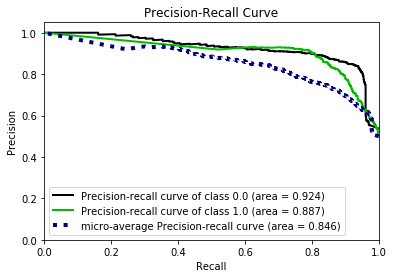

In [24]:
skplt.metrics.plot_precision_recall_curve(y_test_mfcc, y_prob)
plt.show()

#### Define Cutoff

In [25]:
labels = (y_prob > 0.9994).astype(np.int)
labels = labels[:,1]

In [26]:
print(accuracy_score(y_test_mfcc, labels))

0.866502866503


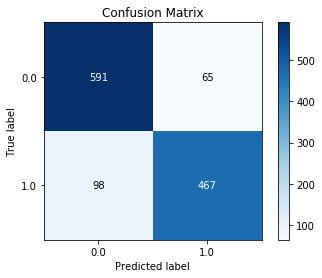

In [27]:
plot_confusion_matrix(y_test_mfcc, labels)
plt.show()

In [28]:
from sklearn.metrics import classification_report
target_names = ['abnormal', 'normal']
print(classification_report(y_test_mfcc, labels, target_names=target_names))

             precision    recall  f1-score   support

   abnormal       0.86      0.90      0.88       656
     normal       0.88      0.83      0.85       565

avg / total       0.87      0.87      0.87      1221



#### Single Sample Prediction 

In [29]:
# Predicts one sample
def predict(file_path, model):
    mfcc = wav2mfcc(file_path, max_seconds=4)
    spec = wav2spec(file_path, max_seconds=4)
    mfcc = mfcc.reshape(1, 20, 63)
    spec = spec.reshape(1, 129, 63, 1)
    x = model.predict([spec, mfcc])
    if (x[:][0][1] < 0.99):
        return ('abnormal : ' + str(x[:][0][1]))
    else:
        return ('normal : ' + str(x[:][0][1]))

In [31]:
predict('data/sample_audio/normal.wav', model)

'normal : 0.999399'

In [32]:
predict('data/sample_audio/murmur.wav', model)

'abnormal : 0.0848314'